In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from kmer_utils.kmer_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
merged_data = pd.read_csv('../data/merged_data.csv')


In [72]:

#{species_id : [six_mer_counts,basecounts]}
species_full_count_data = {}


In [73]:
# Stuff, ignore for now
#k=6
#for spec_id in merged_data['species_id'].unique():
#    species_full_count_data[spec_id] = [{},{}]
#
#    species_df = merged_data[merged_data['species_id'] == spec_id]
#    species_df = species_df[['species_id','upstream200']+[col for col in species_df.columns if 'tpm' in col]]
#
#    ### Count all sixmers 
#    six_mers_counts = {}
#    
#
#    species_df['upstream200'].apply(lambda row: update_kmers_counts(six_mers_counts, [row], k))
#    six_mers_counts = pd.Series(six_mers_counts)
#    six_mers_counts = six_mers_counts.sort_values(ascending=False)
#
#    species_full_count_data[spec_id][0] = six_mers_counts
#
#    ### Count bases at each sixmer location
#    basecounts={'A':[0,0,0,0,0,0],
#                'C':[0,0,0,0,0,0],
#                'G':[0,0,0,0,0,0],
#                'T':[0,0,0,0,0,0]}
#    
#    for seq in six_mers_counts.index:
#        for i, base in enumerate(seq):
#            if base not in basecounts:
#                continue
#            basecounts[base][i] += six_mers_counts[seq]
#
#    # counts to propabilities
#    basecounts = pd.DataFrame(basecounts, index=range(6)).apply(lambda x: x/x.sum(), axis=1)
#    species_full_count_data[spec_id][1] = basecounts
    

        

In [71]:
#pick one below
merged_data['species_id'].unique()

array(['ACHX', 'ACIB', 'AGGA', 'BBURG', 'BURK', 'Campy', 'ENTFA', 'EPEC',
       'ETEC', 'UPEC', 'FRAT', 'HINF', 'HPG27', 'HPJ99', 'KLEBS', 'LEGIP',
       'Listeria', 'MTB', 'NGON', 'NMEN', 'PSEUDO', 'SALMT', 'SHIF',
       'MRSA', 'MSSA', 'SEPI', 'STAGA', 'STRPN', 'SPYO', 'SSUIS',
       'Vibrio', 'YPSTB'], dtype=object)

In [136]:
K = 6
SPEC_ID = 'ACHX'

species_df = merged_data[merged_data['species_id'] == SPEC_ID]

stress_conditions = list(set([col.split("_")[0] for col in species_df.columns if 'tpm' in col]))

kmers_per_tpm = {condition : {} for condition in stress_conditions}
species_df.apply(lambda row: update_kmer_counts_per_tpm(kmers_per_tpm, row, K), axis=1)

kmers_per_tpm = pd.DataFrame(kmers_per_tpm)
kmers_per_tpm.head()

,mig,nd,sp,bs,li,as,oss,ns,vic,oxs,ctrl,tm
CCTTCC,187.984784,159.621295,203.186618,284.845266,161.247043,212.835151,175.716084,203.010634,224.441210,280.119550,314.853108,218.811952
CTTCCA,92.370690,82.026903,109.224876,139.122743,88.391025,97.718614,109.173903,99.556305,111.792720,129.616318,125.361728,97.832749
TTCCAA,66.263442,51.820263,73.180888,97.222256,61.005467,61.337499,74.682756,81.898012,76.724199,100.033334,90.569250,59.061862
TCCAAG,85.577591,58.722323,93.999822,161.592994,75.302528,95.475498,72.641746,106.908132,116.954294,114.233417,129.503240,84.187927
CCAAGC,153.345237,136.841476,202.898972,297.987157,159.299487,177.747601,169.554259,223.841577,216.185579,246.879907,316.498700,169.498013


In [138]:


# normalize by ctrl
kmers_normalized = kmers_per_tpm.div(kmers_per_tpm['ctrl'], axis=0)

kmers_normalized.head()

,mig,nd,sp,bs,li,as,oss,ns,vic,oxs,ctrl,tm
CCTTCC,0.597056,0.506971,0.645338,0.904693,0.512134,0.675982,0.558089,0.644779,0.712844,0.889683,1.0,0.694965
CTTCCA,0.736833,0.654322,0.871278,1.109770,0.705088,0.779493,0.870871,0.794152,0.891761,1.033939,1.0,0.780404
TTCCAA,0.731633,0.572162,0.808010,1.073458,0.673578,0.677244,0.824593,0.904258,0.847133,1.104496,1.0,0.652118
TCCAAG,0.660814,0.453443,0.725849,1.247791,0.581472,0.737244,0.560926,0.825525,0.903099,0.882089,1.0,0.650084
CCAAGC,0.484505,0.432360,0.641074,0.941511,0.503318,0.561606,0.535719,0.707243,0.683054,0.780035,1.0,0.535541


In [150]:
kmers_normalized = kmers_normalized[kmers_normalized.sum(axis=1) > 0]
# drop sequences with N
kmers_normalized = kmers_normalized[~kmers_normalized.index.str.contains('N')]

# get all sequences with 2.5 times or more expression than ctrl
top_stress_seqs = {stress : [] for stress in stress_conditions}

for stress in stress_conditions:
    top_seqs = kmers_normalized[kmers_normalized[stress] > 2.5][stress].sort_values(ascending=False).index
    top_stress_seqs[stress] = top_seqs

for stress in stress_conditions:
    if len(top_stress_seqs[stress]) == 0:
        continue
    print(f"{stress} : {list(top_stress_seqs[stress])}")

bs : ['CCTAAC', 'TTAGTA']
vic : ['TTAGGT', 'TCTTAA', 'TAGGTC']
oxs : ['TACTCT', 'CCTAGT', 'TAAACT', 'CTTATA', 'CCTAAT', 'GCTTAA', 'TAGTCT', 'TTATAC', 'TAACCA']


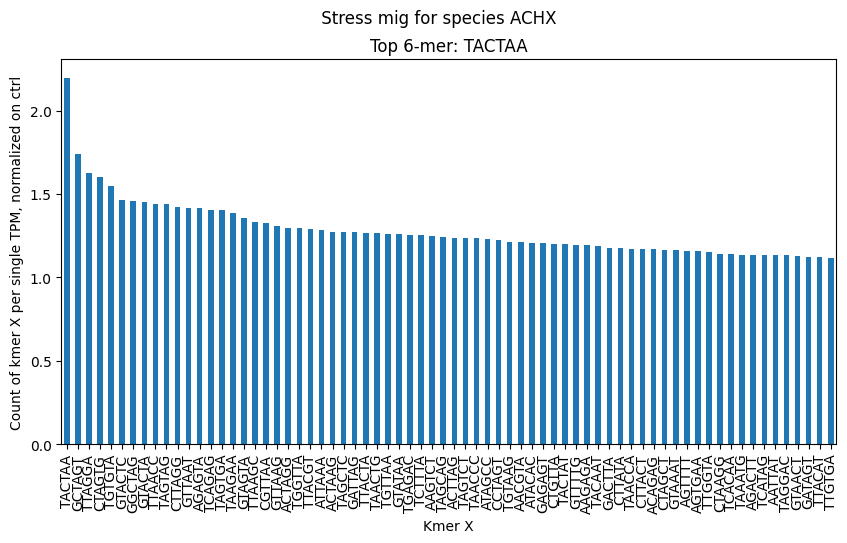

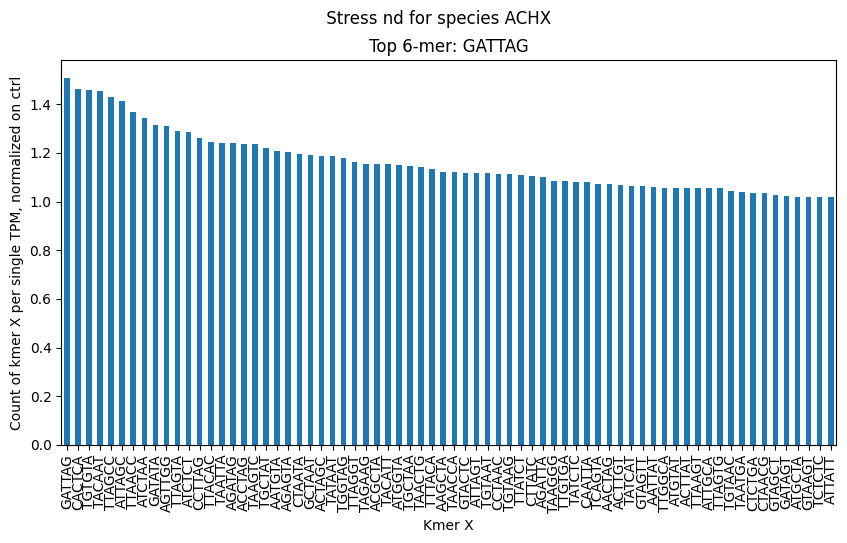

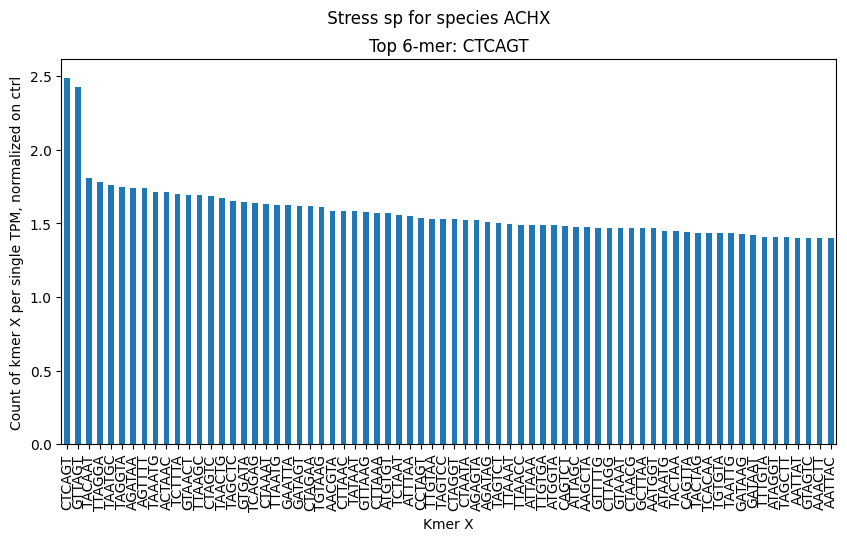

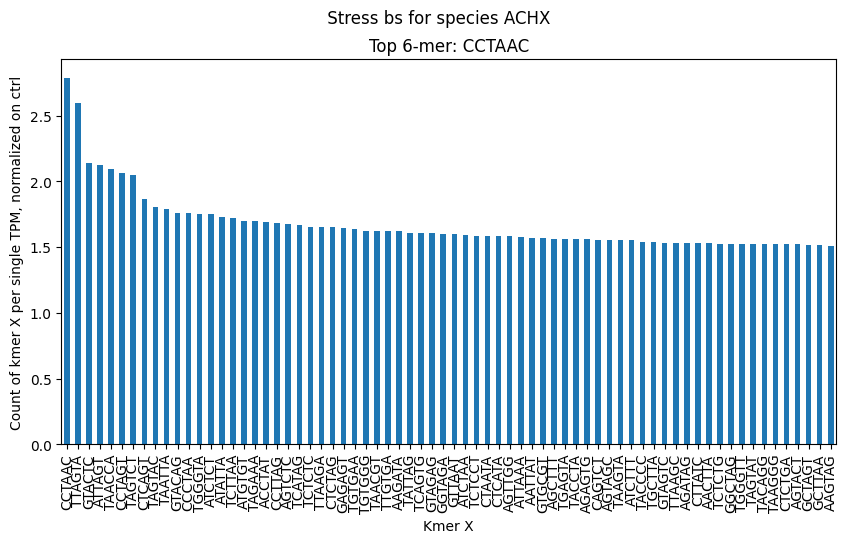

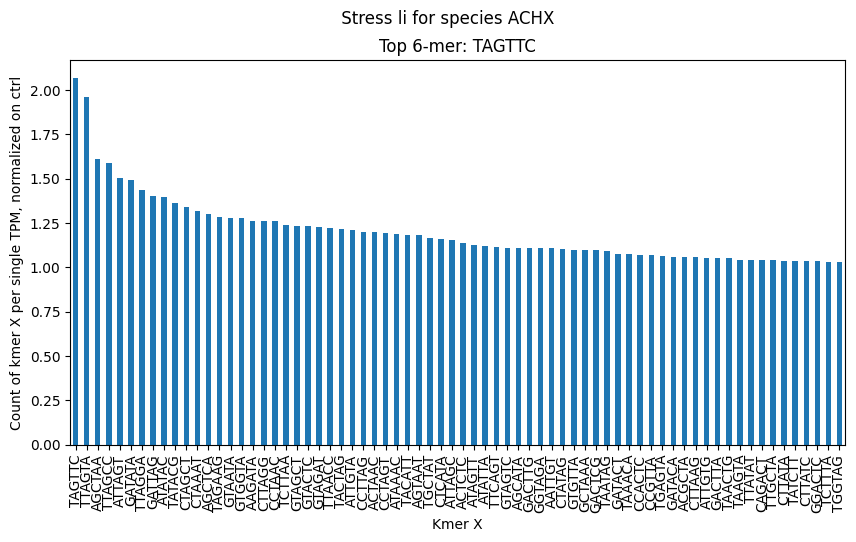

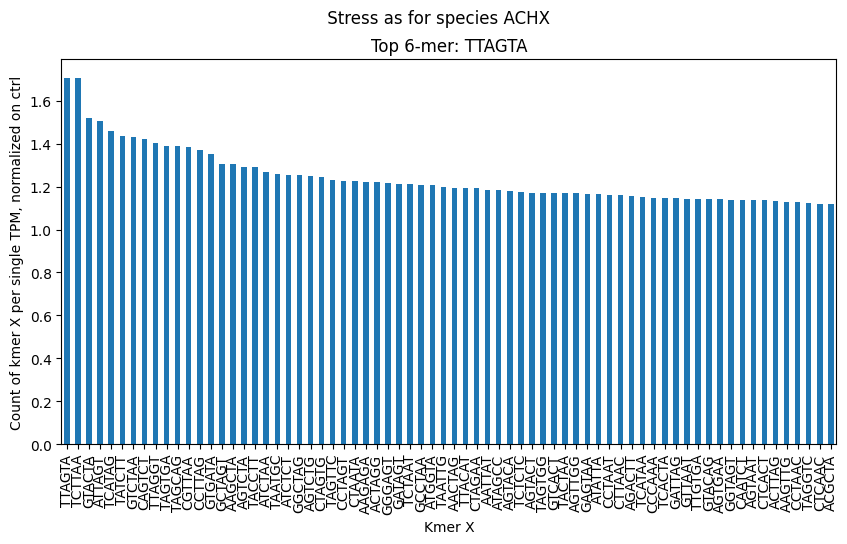

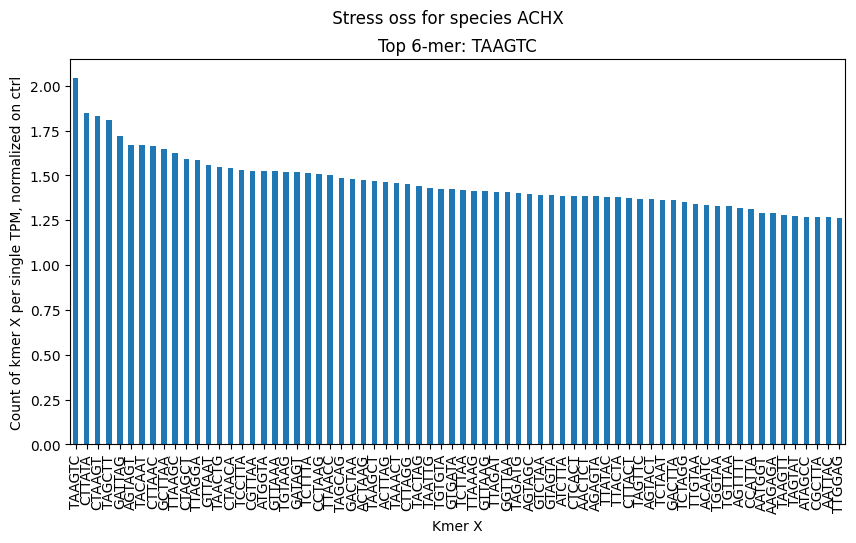

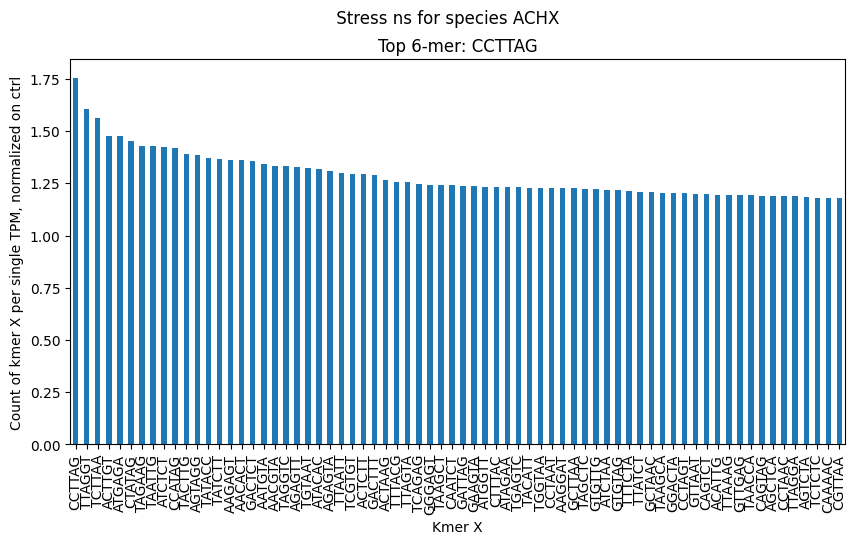

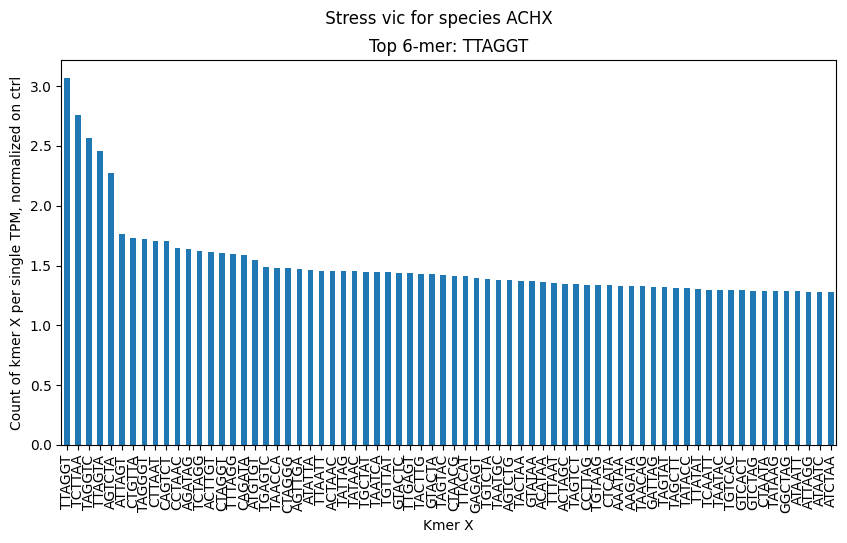

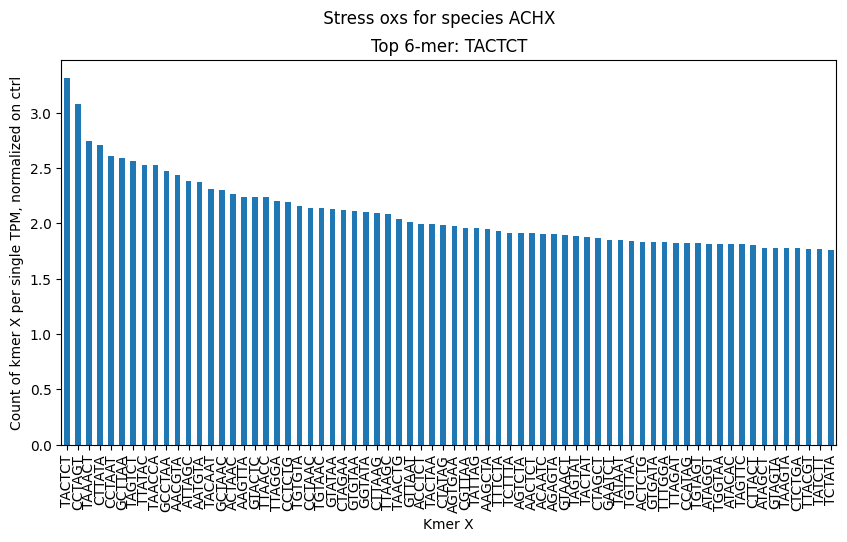

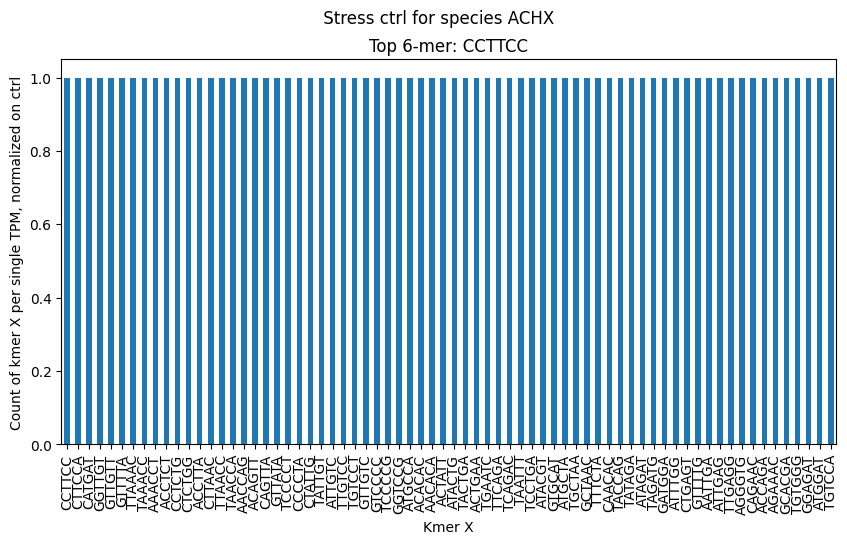

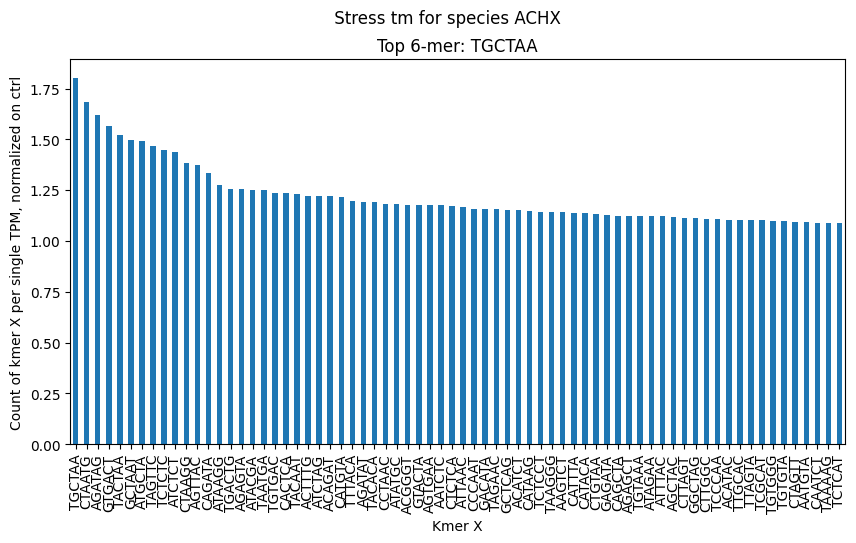

In [141]:



for stress in kmers_normalized.columns:
    # plot top sequences per stress
    tpms = kmers_normalized[stress].sort_values(ascending=False)
    top_seqs = tpms.head(70)

    fig, ax = plt.subplots(1,1, figsize=(10,5))
    top_seqs.plot(kind='bar', ax=ax)
    plt.suptitle(f" Stress {stress} for species {SPEC_ID}")
    plt.title(f"Top {K}-mer: {top_seqs.index[0]}")
    plt.ylabel('Count of kmer X per single TPM, normalized on ctrl')
    plt.xlabel('Kmer X')
    plt.show()



